**Akash Sharma (EE21S056)**

*EE5179: Deep Learning for Imaging*

# MNIST Classification using RNN

## Preliminaries

### Importing required packages

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import sys
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### Preparing dataset

In [2]:
#dset_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
dset_transform = transforms.Compose([transforms.ToTensor()])

train_dset = torchvision.datasets.MNIST(root="data/", train=True, transform= dset_transform, download=True)
test_dset = torchvision.datasets.MNIST(root="data/", train=False, transform= dset_transform, download=True)

In [3]:
# https://discuss.pytorch.org/t/does-torch-utils-data-random-split-split-every-class-equally/43517
# https://discuss.pytorch.org/t/how-to-do-a-stratified-split/62290?msclkid=cdbabbe8c1bb11ecbfa1268a15c4fbd4

train_targets = train_dset.targets

# Split indices using stratify
train_idx, val_idx = train_test_split(np.arange(len(train_targets)), test_size=1/6, shuffle = True, stratify = train_targets)

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

train_loader = DataLoader(train_dset, batch_size=100, sampler = train_sampler)
val_loader = DataLoader(train_dset, batch_size = 100, sampler = val_sampler)
test_loader = DataLoader(test_dset, batch_size = 100, shuffle = False)

In the above code cell, training and testing MNIST datasets have been called. However in the assignment, an additional condition has been imposed i.e., the train, test and validation split should have equal representation from all $10$ classes of images. To this end, we use [**stratified split**](https://scikit-learn.org/stable/modules/cross_validation.html#stratification) on `train_dset` into training and validation splits. This ensures that all the classes are equally represented in `train_dset` and `val_dset`. This approach has not been applied to impose this condition on `test_dset` as it is assumed that it follows this condition already. 

Since `PyTorch` does not have a straightforward method for a stratified split, `sklearn` has been used for the same. 

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Setting up hyperparameters

Standard set of hyperparameters has been chosen and it seems to perform well for all the three models in this section. Some minor improvement was observed when using stacked RNN.

In [5]:
input_size = 28
sequence_length = 28
num_layers = 1
hidden_size = 128
num_classes = 10
learning_rate = 0.001
num_epochs = 10

## Vanilla RNN

### Vanilla RNN definition

In [6]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_size*sequence_length, num_classes)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

    out, _ = self.rnn(x, h0)
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [7]:
model_rnn = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_rnn.parameters(), lr = learning_rate)

train_batch_loss = []
train_epoch_loss = []
val_loss = []
val_acc = []

### Vanilla RNN Training

In [8]:
for epoch in range(num_epochs):
  for batch_idx, (data, targets) in enumerate(train_loader):
    data = data.to(device=device).squeeze(1)
    targets = targets.to(device=device)

    scores = model_rnn(data)
    loss = criterion(scores, targets)
    train_batch_loss.append(loss.item())

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

  train_epoch_loss.append(train_batch_loss[-1])
  iter = 0
  val_iter_loss = 0
  val_num_correct = 0

  for data, targets in val_loader:
    data = data.to(device=device).squeeze(1)
    targets = targets.to(device=device)

    scores = model_rnn(data)
    loss = criterion(scores, targets)
    _, predictions = scores.max(1)
    val_num_correct += (predictions == targets).sum().item()
    iter += 1
    val_iter_loss += loss.item()

  val_loss.append(val_iter_loss/iter)
  val_acc.append(val_num_correct/100)
  print('Epoch Number: ',epoch+1)
  print('Training loss: ', train_epoch_loss[-1])
  print('Validation loss: ', val_loss[-1])
  print('Validation Accuracy: ', val_acc[-1])
  print('-----------------------------------------')

print('Training done!')

Epoch Number:  1
Training loss:  0.2069898247718811
Validation loss:  0.246353093162179
Validation Accuracy:  92.25
-----------------------------------------
Epoch Number:  2
Training loss:  0.09365565329790115
Validation loss:  0.15064502827823162
Validation Accuracy:  95.39
-----------------------------------------
Epoch Number:  3
Training loss:  0.09746860712766647
Validation loss:  0.10445927729830146
Validation Accuracy:  96.68
-----------------------------------------
Epoch Number:  4
Training loss:  0.11115830391645432
Validation loss:  0.09107255920767784
Validation Accuracy:  97.21
-----------------------------------------
Epoch Number:  5
Training loss:  0.05853547528386116
Validation loss:  0.08905094034038484
Validation Accuracy:  97.21
-----------------------------------------
Epoch Number:  6
Training loss:  0.02182864025235176
Validation loss:  0.06973584928549827
Validation Accuracy:  98.04
-----------------------------------------
Epoch Number:  7
Training loss:  0.10

### Loss and accuracy plots for Vanilla RNN

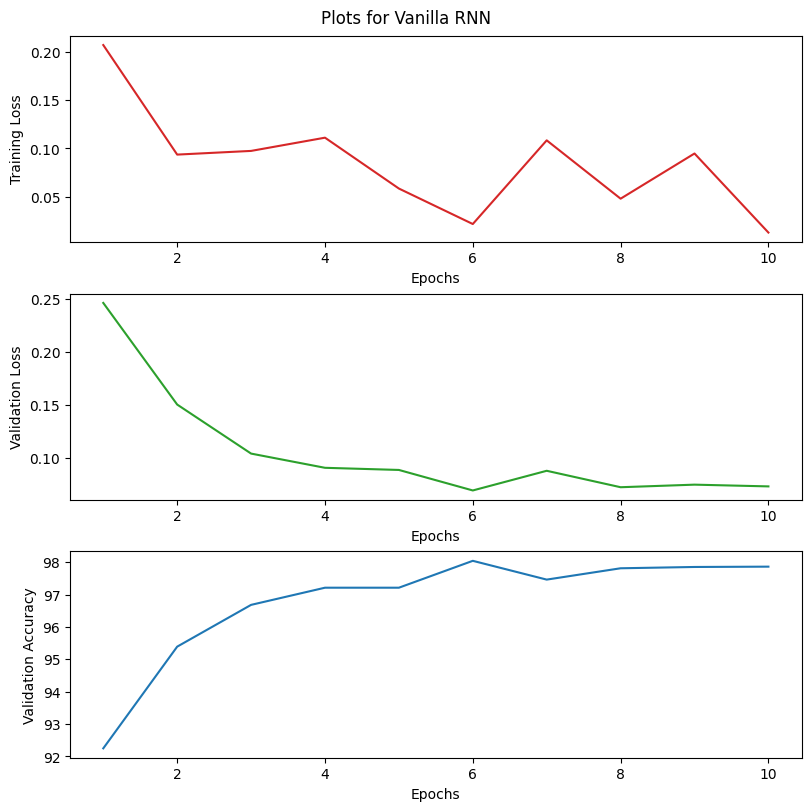

In [9]:
fig, axs = plt.subplots(3, constrained_layout= True, figsize=(8,8))
fig.suptitle('Plots for Vanilla RNN')
axs[0].set(ylabel='Training Loss', xlabel='Epochs')
axs[0].plot(range(1,num_epochs+1),train_epoch_loss, 'tab:red')
axs[1].set(ylabel='Validation Loss', xlabel='Epochs')
axs[1].plot(range(1,num_epochs+1),val_loss, 'tab:green')
axs[2].set(ylabel='Validation Accuracy', xlabel='Epochs')
axs[2].plot(range(1,num_epochs+1),val_acc)


**Prediction accuracy on the test set for vanilla RNN is given below.**

In [10]:
def prediction_accuracy(loader, model):
  num_correct = 0
  num_samples = 0

  model.eval()

  with torch.no_grad():
    for x, y in loader:
      x = x.to(device=device).squeeze(1)
      y = y.to(device=device)

      scores = model(x)
      _, predictions = scores.max(1)
      num_correct += (predictions == y).sum()
      num_samples += predictions.size(0)

  return num_correct / num_samples

print(f"Accuracy on test set: {prediction_accuracy(test_loader, model_rnn)*100:.2f} for Vanilla RNN")

Accuracy on test set: 98.11 for Vanilla RNN


## LSTM

### LSTM definition

In [11]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
    super(LSTM, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_size*sequence_length, num_classes)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

    out, _ = self.lstm(x, (h0, c0))
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [12]:
model_lstm = LSTM(input_size, hidden_size, num_layers, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_lstm.parameters(), lr = learning_rate)

train_batch_loss = []
train_epoch_loss = []
val_loss = []
val_acc = []

### LSTM Training

In [13]:
for epoch in range(num_epochs):
  for batch_idx, (data, targets) in enumerate(train_loader):
    data = data.to(device=device).squeeze(1)
    targets = targets.to(device=device)

    scores = model_lstm(data)
    loss = criterion(scores, targets)
    train_batch_loss.append(loss.item())

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

  train_epoch_loss.append(train_batch_loss[-1])
  iter = 0
  val_iter_loss = 0
  val_num_correct = 0

  for data, targets in val_loader:
    data = data.to(device=device).squeeze(1)
    targets = targets.to(device=device)

    scores = model_lstm(data)
    loss = criterion(scores, targets)
    _, predictions = scores.max(1)
    val_num_correct += (predictions == targets).sum().item()
    iter += 1
    val_iter_loss += loss.item()

  val_loss.append(val_iter_loss/iter)
  val_acc.append(val_num_correct/100)
  print('Epoch Number: ',epoch+1)
  print('Training loss: ', train_epoch_loss[-1])
  print('Validation loss: ', val_loss[-1])
  print('Validation Accuracy: ', val_acc[-1])
  print('-----------------------------------------')

print('Training done!')

Epoch Number:  1
Training loss:  0.14614233374595642
Validation loss:  0.14662306483834983
Validation Accuracy:  95.39
-----------------------------------------
Epoch Number:  2
Training loss:  0.03872161731123924
Validation loss:  0.07385913086123765
Validation Accuracy:  97.73
-----------------------------------------
Epoch Number:  3
Training loss:  0.13927438855171204
Validation loss:  0.06171097332146019
Validation Accuracy:  98.07
-----------------------------------------
Epoch Number:  4
Training loss:  0.06874502450227737
Validation loss:  0.06985988560132682
Validation Accuracy:  97.77
-----------------------------------------
Epoch Number:  5
Training loss:  0.011632125824689865
Validation loss:  0.0500463926140219
Validation Accuracy:  98.26
-----------------------------------------
Epoch Number:  6
Training loss:  0.004016758408397436
Validation loss:  0.04048532999120653
Validation Accuracy:  98.77
-----------------------------------------
Epoch Number:  7
Training loss:  

### Loss and accuracy plots for LSTM variant

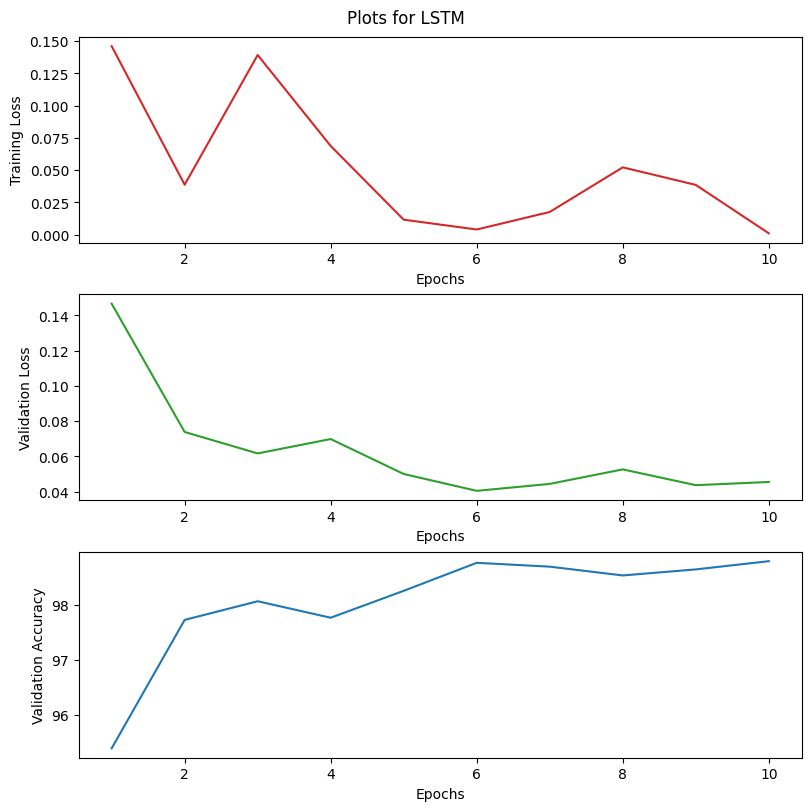

In [14]:
fig, axs = plt.subplots(3, constrained_layout= True, figsize=(8,8))
fig.suptitle('Plots for LSTM')
axs[0].set(ylabel='Training Loss', xlabel='Epochs')
axs[0].plot(range(1,num_epochs+1),train_epoch_loss, 'tab:red')
axs[1].set(ylabel='Validation Loss', xlabel='Epochs')
axs[1].plot(range(1,num_epochs+1),val_loss, 'tab:green')
axs[2].set(ylabel='Validation Accuracy', xlabel='Epochs')
axs[2].plot(range(1,num_epochs+1),val_acc)


**Prediction accuracy on the test set for LSTM model is given below.**

In [15]:
print(f"Accuracy on test set: {prediction_accuracy(test_loader, model_lstm)*100:.2f} for LSTM")

Accuracy on test set: 98.73 for LSTM


## Bidirectional RNN

### Bidirectional RNN definition

In [16]:
class bi_LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
    super(bi_LSTM, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True, bidirectional = True)
    self.fc = nn.Linear(hidden_size*2, num_classes)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
    c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)

    out, _ = self.lstm(x, (h0, c0)) # second output is a tuple of hidden state and cell state
    out = self.fc(out[:, -1, :])
    return out

In [17]:
model_bilstm = bi_LSTM(input_size, hidden_size, num_layers, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_bilstm.parameters(), lr = learning_rate)

train_batch_loss = []
train_epoch_loss = []
val_loss = []
val_acc = []

### Bidirectional RNN training

In [18]:
for epoch in range(num_epochs):
  for batch_idx, (data, targets) in enumerate(train_loader):
    data = data.to(device=device).squeeze(1)
    targets = targets.to(device=device)

    scores = model_bilstm(data)
    loss = criterion(scores, targets)
    train_batch_loss.append(loss.item())

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

  train_epoch_loss.append(train_batch_loss[-1])
  iter = 0
  val_iter_loss = 0
  val_num_correct = 0

  for data, targets in val_loader:
    data = data.to(device=device).squeeze(1)
    targets = targets.to(device=device)
    scores = model_bilstm(data)
    loss = criterion(scores, targets)
    _, predictions = scores.max(1)
    val_num_correct += (predictions == targets).sum().item()
    iter += 1
    val_iter_loss += loss.item()

  val_loss.append(val_iter_loss/iter)
  val_acc.append(val_num_correct/100)
  print('Epoch Number: ',epoch+1)
  print('Training loss: ', train_epoch_loss[-1])
  print('Validation loss: ', val_loss[-1])
  print('Validation Accuracy: ', val_acc[-1])
  print('-----------------------------------------')

print('Training done!')

Epoch Number:  1
Training loss:  0.2739512026309967
Validation loss:  0.25337998509407045
Validation Accuracy:  92.23
-----------------------------------------
Epoch Number:  2
Training loss:  0.12995198369026184
Validation loss:  0.1408264897018671
Validation Accuracy:  95.76
-----------------------------------------
Epoch Number:  3
Training loss:  0.18433429300785065
Validation loss:  0.10163045018911361
Validation Accuracy:  96.97
-----------------------------------------
Epoch Number:  4
Training loss:  0.12460952997207642
Validation loss:  0.10851725235581398
Validation Accuracy:  96.68
-----------------------------------------
Epoch Number:  5
Training loss:  0.10866312682628632
Validation loss:  0.07782521922141314
Validation Accuracy:  97.74
-----------------------------------------
Epoch Number:  6
Training loss:  0.09004197269678116
Validation loss:  0.06973135408014058
Validation Accuracy:  98.0
-----------------------------------------
Epoch Number:  7
Training loss:  0.03

### Loss and accuracy plots for bidirectional RNN

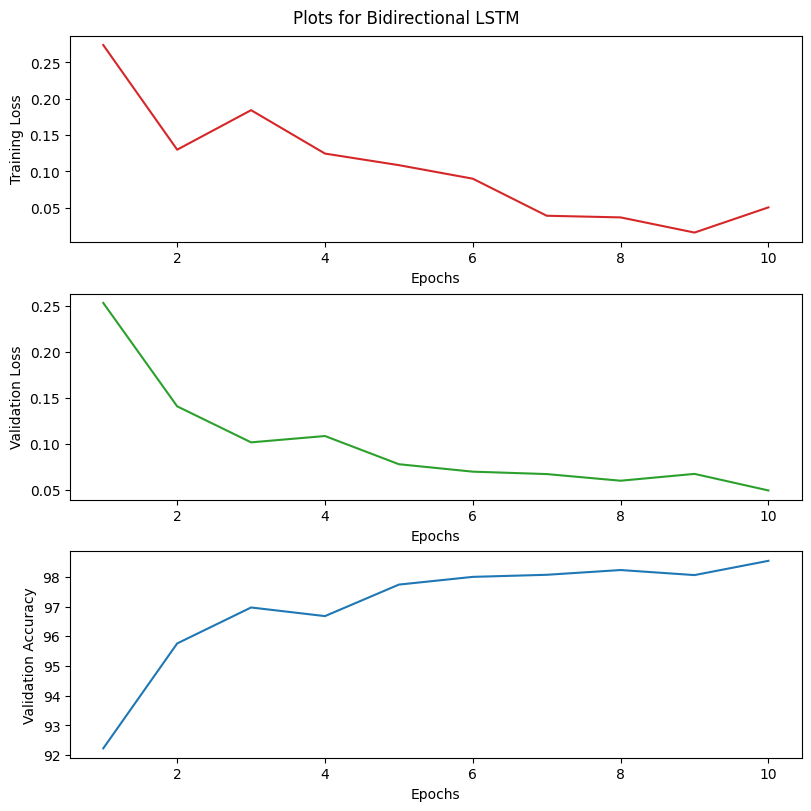

In [19]:
fig, axs = plt.subplots(3, constrained_layout= True, figsize=(8,8))
fig.suptitle('Plots for Bidirectional LSTM')
axs[0].set(ylabel='Training Loss', xlabel='Epochs')
axs[0].plot(range(1,num_epochs+1),train_epoch_loss, 'tab:red')
axs[1].set(ylabel='Validation Loss', xlabel='Epochs')
axs[1].plot(range(1,num_epochs+1),val_loss, 'tab:green')
axs[2].set(ylabel='Validation Accuracy', xlabel='Epochs')
axs[2].plot(range(1,num_epochs+1),val_acc)

**Prediction accuracy on the test set for bidirectional RNN is given below.**

In [20]:
print(f"Accuracy on test set: {prediction_accuracy(test_loader, model_bilstm)*100:.2f} for bidirectional LSTM")

Accuracy on test set: 98.48 for bidirectional LSTM


## Predicted vs. True Labels

We now see for some test samples if the predicted value is actually the same as the true label. As can be seen previously, all three model variants have high accuracy therefore in general for most of the random test samples, the predicted label and the true label would be same.

In [21]:
rand_idx = (10*np.abs(np.random.rand(10))).astype(int)
for i in range(10):
  _, predictions = scores[rand_idx[i]].max(0)
  print('Predicted label is', predictions.item())
  print('True label is', targets[rand_idx[i]].item())
  print('-----------------------------------------')

Predicted label is 0
True label is 0
-----------------------------------------
Predicted label is 4
True label is 4
-----------------------------------------
Predicted label is 4
True label is 4
-----------------------------------------
Predicted label is 1
True label is 1
-----------------------------------------
Predicted label is 6
True label is 6
-----------------------------------------
Predicted label is 6
True label is 6
-----------------------------------------
Predicted label is 7
True label is 7
-----------------------------------------
Predicted label is 1
True label is 1
-----------------------------------------
Predicted label is 1
True label is 1
-----------------------------------------
Predicted label is 4
True label is 4
-----------------------------------------


## Inferences on custom dataset

A custom test dataset containing 12 images of handwritten digits is formed. Originally, images have been captured using a smartphone camera in 1:1 ratio for image dimensions in the `.jpg` format. These images have been saved in the working directory in the folder named `custom_data_orig`. Before running any sort of inferences on these images, they have to be preprocessed such that they comply with the standards of the MNIST dataset. This preprocessing has been done in the following code cell and inference using the best performing model `model_lstm` has been done.

Custom test images: 


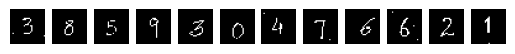

Predictions for each of the above images given by model_lstm is: 
[3, 2, 5, 9, 2, 7, 4, 7, 3, 6, 2, 1]


In [22]:
import os
import cv2 as cv
import glob

in_path = 'custom_data_orig'
#os.mkdir('custom_processed')

i=0
custom_predictions = []

for img in glob.glob(in_path+"/*.jpg"):
    img_gray = cv.imread(img, 0) #grayscale
    img_res = cv.resize(img_gray, (28,28)) #resize to MNIST dimensions
    img_fin = cv.bitwise_not(img_res) #invert
    img_fin[img_fin>127]=255 # Binarizing the image
    img_fin[img_fin!=255]=0
    img_fin = img_fin/255 #Normalized
    
    # plotting input images
    i+=1
    plt.subplot(1,12,i)
    plt.imshow(img_fin, cmap='gray')
    plt.axis('off')

    # preparing input for the model
    img_fin= torch.from_numpy(img_fin)
    img_fin = torch.unsqueeze(img_fin, dim=0).to(device=device).float()
    scores = model_lstm(img_fin)
    _, predictions = scores.max(1) # get predictions
    custom_predictions.append(predictions.item())

print('Custom test images: ')
plt.show()
print('Predictions for each of the above images given by model_lstm is: ')
print(custom_predictions)

It is observed that some of the predictions are not correct from visual inspection but the model performs fairly well on this custom test set. However, it does not reflect the same as it did in its test accuracy. Inspecting closely, it can be seen the model does not perform well if the number is not in the `20x20` window (which is the condition for the number position in the MNIST dataset) or is a bit distorted. There are also some artefacts in the vicinity of the numbers which could be the cause for the misclassification.

# Remembering the number at a particular index in a given sequence

## Preparing dataset & utility functions

In [23]:
train_seq = []
test_seq = []

def sequence(L):
  seq = np.random.randint(0,10,L)
  return seq

for i in range(100):
  for j in range(3,12):
    train_seq.append(sequence(j))
  L = np.random.randint(3,11)
  test_seq.append(sequence(L))

In [24]:
# Function definition for one hot encoding the input sequence

def onehotencode(num):
  ohe_num = np.zeros((len(num), 10))
  ohe_num[np.arange(len(num)), num] = 1
  return ohe_num

## Model definition

In [25]:
class seq_LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
    super(seq_LSTM, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
    self.fc = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
    x=x.permute(1,0,2)
    out, (hid, cel) = self.lstm(x, (h0, c0))
    out = self.fc(out[-1])
    return out.reshape(1, num_classes)

## Parameter Initialization

Consider, we want to remember the number at the third position in a given sequence, so we set the parameter `pos` = 2 (since index begins from 0). Other initialization and choice of parameters have been adjusted after experimentation to get acceptable results.

In [26]:
input_size = 10
num_layers = 1
num_classes = 10

criterion = nn.CrossEntropyLoss()
epochs = 20
learning_rate = 0.002

# We are interested in the 3rd position in the sequence
pos = 2 

hid_size = [2,5,10]
train_loss2 = []
train_loss5 = []
train_loss10 = []
train_epoch_loss2 = []
train_epoch_loss5 = []
train_epoch_loss10 = []

## Model training

Models with different hidden state sizes are trained.

### Training LSTM model with hidden state size 2

In [27]:
model_seq_LSTM2 = seq_LSTM(input_size, hid_size[0], num_layers, num_classes)
optim2 = torch.optim.Adam(model_seq_LSTM2.parameters(), learning_rate)

for epoch in range(epochs):
  for i in range(len(train_seq)):
    ohe_seq = torch.zeros((1, len(train_seq[i]), 10))
    ohe_seq[0] = torch.from_numpy(onehotencode(train_seq[i]))

    scores = model_seq_LSTM2(ohe_seq.float())
    _, predictions = scores.max(1)

    target = torch.tensor([train_seq[i][pos]], dtype = torch.long)
    loss = criterion(scores, target.long())
    train_loss2.append(loss.item())

    optim2.zero_grad()
    loss.backward()
    optim2.step()
  
  train_epoch_loss2.append(train_loss2[-1])

### Training LSTM model with hidden state size 5

In [28]:
model_seq_LSTM5 = seq_LSTM(input_size, hid_size[1], num_layers, num_classes)
optim5 = torch.optim.Adam(model_seq_LSTM5.parameters(), learning_rate)

for epoch in range(epochs):
  for i in range(len(train_seq)):
    ohe_seq = torch.zeros((1, len(train_seq[i]), 10))
    ohe_seq[0] = torch.from_numpy(onehotencode(train_seq[i]))

    scores = model_seq_LSTM5(ohe_seq.float())
    _, predictions = scores.max(1)

    target = torch.tensor([train_seq[i][pos]], dtype = torch.long)
    loss = criterion(scores, target.long())
    train_loss5.append(loss.item())

    optim5.zero_grad()
    loss.backward()
    optim5.step()

  train_epoch_loss5.append(train_loss5[-1])

### Training LSTM model with hidden state size 10

In [29]:
model_seq_LSTM10 = seq_LSTM(input_size, hid_size[2], num_layers, num_classes)
optim10 = torch.optim.Adam(model_seq_LSTM10.parameters(), learning_rate)

for epoch in range(epochs):
  for i in range(len(train_seq)):
    ohe_seq = torch.zeros((1, len(train_seq[i]), 10))
    ohe_seq[0] = torch.from_numpy(onehotencode(train_seq[i]))

    scores = model_seq_LSTM10(ohe_seq.float())
    _, predictions = scores.max(1)

    target = torch.tensor([train_seq[i][pos]], dtype = torch.long)
    loss = criterion(scores, target.long())
    train_loss10.append(loss.item())

    optim10.zero_grad()
    loss.backward()
    optim10.step()
  
  train_epoch_loss10.append(train_loss10[-1])

## Training loss plots for LSTM with different hidden state sizes

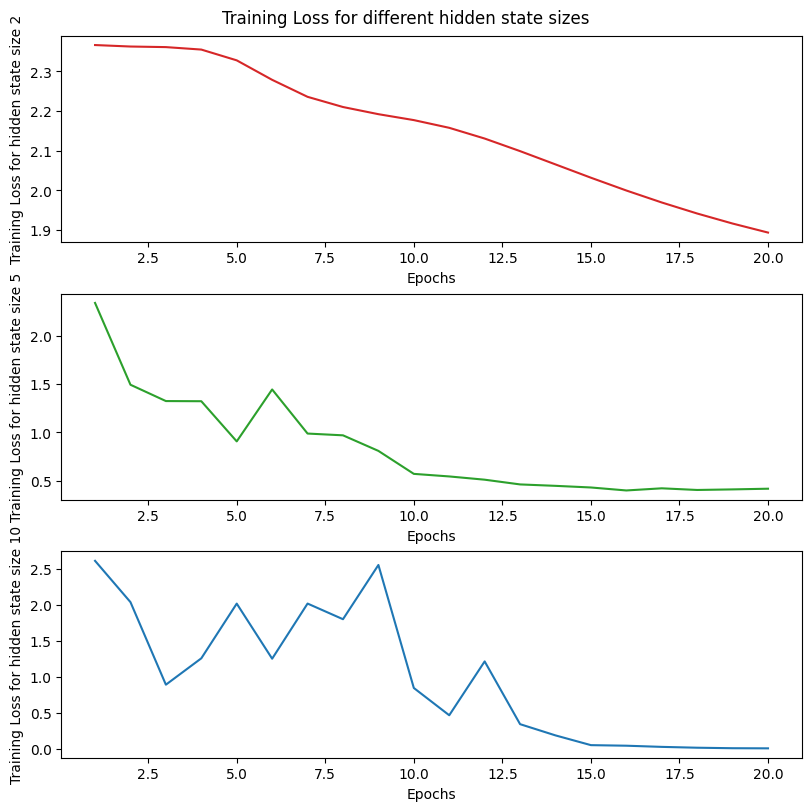

In [30]:
fig, axs = plt.subplots(3, constrained_layout= True, figsize=(8,8))
fig.suptitle('Training Loss for different hidden state sizes')
axs[0].set(ylabel='Training Loss for hidden state size 2', xlabel='Epochs')
axs[0].plot(range(1,epochs+1),train_epoch_loss2, 'tab:red')
axs[1].set(ylabel='Training Loss for hidden state size 5', xlabel='Epochs')
axs[1].plot(range(1,epochs+1),train_epoch_loss5, 'tab:green')
axs[2].set(ylabel='Training Loss for hidden state size 10', xlabel='Epochs')
axs[2].plot(range(1,epochs+1),train_epoch_loss10)

## Prediction accuracy on test set for LSTM with different hidden state sizes

### Accuracy function definition

In [31]:
def check_accuracy(test_seq, model):
  num_correct = 0
  num_samples = 0

  model.eval()

  with torch.no_grad():
    for i in range(len(test_seq)):
      ohe_seq = torch.zeros((1, len(test_seq[i]), 10))
      ohe_seq[0] = torch.from_numpy(onehotencode(test_seq[i]))

      scores = model(ohe_seq.float())
      target = torch.tensor([test_seq[i][pos]], dtype = torch.long)
      _, predictions = scores.max(1)
      num_correct += (predictions == target).sum().item()
      num_samples += predictions.size(0)
      
  return num_correct / num_samples

### Accuracy on test set for LSTM with different hidden state sizes

In [32]:
print(f"Accuracy on test set: {check_accuracy(test_seq, model_seq_LSTM2)*100:.2f} for LSTM with hidden state size = 2.")
print(f"Accuracy on test set: {check_accuracy(test_seq, model_seq_LSTM5)*100:.2f} for LSTM with hidden state size = 5.")
print(f"Accuracy on test set: {check_accuracy(test_seq, model_seq_LSTM10)*100:.2f} for LSTM with hidden state size = 10.")

Accuracy on test set: 24.00 for LSTM with hidden state size = 2.
Accuracy on test set: 31.00 for LSTM with hidden state size = 5.
Accuracy on test set: 100.00 for LSTM with hidden state size = 10.


## Input vs. predicted number

Below we see what the predicted number is for a given input at a chosen position (in this case, 3) for different sequence lengths varying from 3 to 11. The model for the predictions here is the one with hidden state size equal to 10 which showed much better accuracy on the test set because of its higher capacity for state propagation at different time steps.

In [33]:
for L in range(3,12):
  print("Sequence length: ", L)
  for i in range(5):
    x = sequence(L)
    ohe_x = torch.zeros((1,len(x), 10))
    ohe_x[0]=torch.from_numpy(onehotencode(x))

    scores = model_seq_LSTM10(ohe_x.float())
    target = torch.tensor(x[pos], dtype=torch.long)
    _, predictions = scores.max(1)
    print("Given input: ",x, "Prediction at position 3: ", predictions.item())
  print('---------------------------------------------')

Sequence length:  3
Given input:  [1 4 1] Prediction at position 3:  1
Given input:  [0 3 3] Prediction at position 3:  3
Given input:  [7 0 3] Prediction at position 3:  3
Given input:  [3 7 0] Prediction at position 3:  0
Given input:  [5 1 9] Prediction at position 3:  9
---------------------------------------------
Sequence length:  4
Given input:  [8 5 7 7] Prediction at position 3:  7
Given input:  [5 3 3 2] Prediction at position 3:  3
Given input:  [8 2 6 0] Prediction at position 3:  6
Given input:  [4 9 0 6] Prediction at position 3:  0
Given input:  [2 5 6 6] Prediction at position 3:  6
---------------------------------------------
Sequence length:  5
Given input:  [9 1 1 0 7] Prediction at position 3:  1
Given input:  [6 8 6 7 1] Prediction at position 3:  6
Given input:  [4 6 8 7 8] Prediction at position 3:  8
Given input:  [2 1 2 9 4] Prediction at position 3:  2
Given input:  [9 4 5 9 1] Prediction at position 3:  5
---------------------------------------------
Sequenc

# Adding two binary inputs

## Preparing dataset

### Defining utility functions

`gen_binary(L)` function generates an input-output pair randomly for a given bit sequence `L`. The input is a 2-tuple of binary sequences of numbers which are supposed to be added and the output is the corresponding binary sequence for the addition of the two numbers.

In [34]:
def gen_binary(L):
  a = np.random.randint(0, 2**(L-1))
  b = np.random.randint(0, 2**(L-1))
  c = a+b
  binary_length = L
  a_bin = np.zeros((1, binary_length))
  b_bin = np.zeros((1, binary_length))
  c_bin = np.zeros((binary_length))
  x = np.flip(np.array(list(np.binary_repr(a)), dtype=int))
  a_bin[0][0:len(x)]=x[0:]
  x = np.flip(np.array(list(np.binary_repr(b)), dtype=int))
  b_bin[0][0:len(x)]=x[0:]
  x = np.flip(np.array(list(np.binary_repr(c)), dtype=int))
  c_bin[0:len(x)]=x[0:]

  return(np.concatenate((np.transpose(a_bin), np.transpose(b_bin)), axis=1), c_bin)

### Dataset

The train dataset has 500 input-output pairs while the validation dataset has 100 such samples. The input sequence length is chosen randomly from values 1 to 20 and is fixed for the training set. Then for the validation set, it is chosen randomly again and fixed.

In [35]:
train_in = []
train_out = []

for i in range(500):
  L = np.random.randint(1,21)
  a, b = gen_binary(L)
  train_in.append(a)
  train_out.append(b)

val_in = []
val_out = []

for i in range(100):
  L = np.random.randint(1,21)
  a, b = gen_binary(L)
  val_in.append(a)
  val_out.append(b)


## Adder LSTM Model Definition

In [36]:
class add_LSTM(nn.Module):
  def __init__(self, hidden_size):
    super(add_LSTM, self).__init__()
    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(2, hidden_size)
    self.layer = nn.Sequential(nn.Linear(hidden_size, 1), nn.Sigmoid())

  def forward(self, x):
    h0 = torch.zeros(1, x.size(0), self.hidden_size)
    c0 = torch.zeros(1, x.size(0), self.hidden_size)
    x=x.permute(1,0,2)
    out, (hid, cel) = self.lstm(x, (h0, c0))
    out = self.layer(out)
    return out.reshape(x.size(0))

## Training adder model

### Training function definition

In [37]:
def train(model, criterion, optimiser, train_in, train_out):
  train_loss = []
  train_epoch_loss = []
  val_loss = []
  num_correct = []

  for epoch in range(epochs):
    for i in range(int(len(train_in))):
      x = torch.zeros((1, train_in[i].shape[0], train_in[i].shape[1]))
      x[0] = torch.from_numpy(train_in[i])
      out = model(x.float())
      target = torch.tensor(np.transpose(train_out[i]))
      loss = criterion(out, target.float())
      train_loss.append(loss.item())

      optimiser.zero_grad()
      loss.backward()
      optimiser.step()
    
    train_epoch_loss.append(train_loss[-1])

    iter = 0
    valloss = 0

    for i in range(len(val_in)):
      correct = 0
      x = torch.zeros((1, val_in[i].shape[0], val_in[i].shape[1]))
      x[0] = torch.from_numpy(val_in[i])

      out = model(x.float())
      target = torch.tensor(np.transpose(val_out[i]))
      loss = criterion(out, target.float())
      iter += 1
      valloss += loss.item()

      prediction = torch.zeros(out.shape)
      prediction[out>=0.5] = 1
      prediction[out<0.5] = 0
      correct += (prediction == target.float()).sum().item()/len(target)

    num_correct.append(100*correct)
    val_loss.append(valloss/iter)
  return train_epoch_loss, val_loss, num_correct

## Training adder LSTM with MSE loss criterion and different hidden state sizes

Different state vector sizes are chosen viz., 3, 5 and 10. The loss criterion is mean squared error (MSE) loss. 

### Training all model variations with MSE loss criterion

In [38]:
# Fixing loss criterion
mse_criterion = nn.MSELoss()

modelH3_MSE = add_LSTM(3)
optimH3 = torch.optim.Adam(modelH3_MSE.parameters(), learning_rate)
modelH5_MSE = add_LSTM(5)
optimH5 = torch.optim.Adam(modelH5_MSE.parameters(), learning_rate)
modelH10_MSE = add_LSTM(10)
optimH10 = torch.optim.Adam(modelH10_MSE.parameters(), learning_rate)

In [39]:
# setting hyperparameters
learning_rate = 0.001
epochs = 10

# Training
train_lossH3, val_lossH3, num_correctH3  = train(modelH3_MSE, mse_criterion, optimH3, train_in, train_out)
train_lossH5, val_lossH5, num_correctH5  = train(modelH5_MSE, mse_criterion, optimH5, train_in, train_out)
train_lossH10, val_lossH10, num_correctH10  = train(modelH10_MSE, mse_criterion, optimH10, train_in, train_out)

### Training and validation plots for all model variations with MSE loss criterion

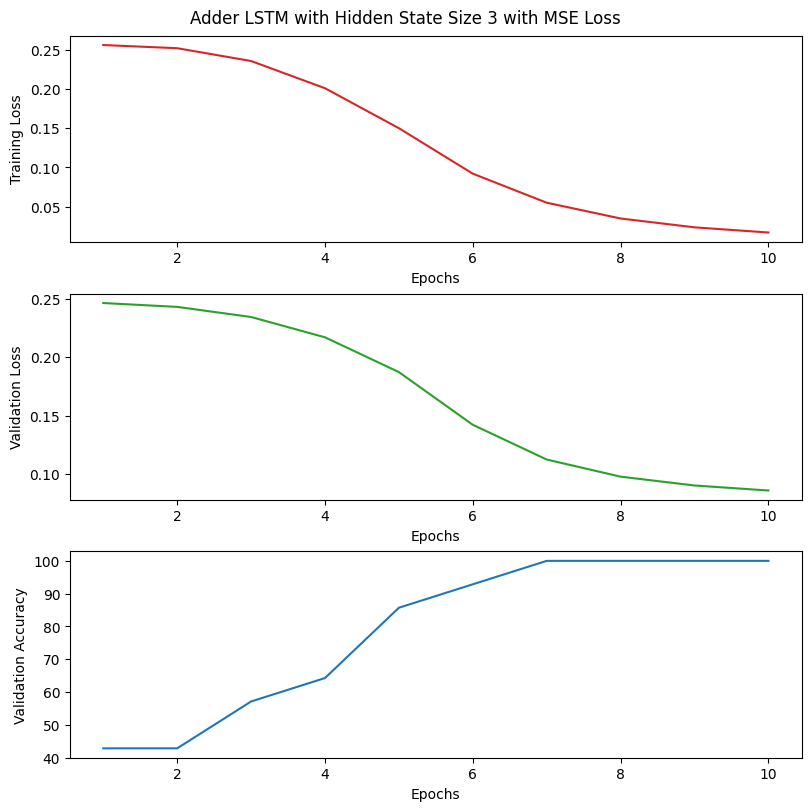

In [40]:
fig, axs = plt.subplots(3, constrained_layout= True, figsize=(8,8))
fig.suptitle('Adder LSTM with Hidden State Size 3 with MSE Loss')
axs[0].set(ylabel='Training Loss', xlabel='Epochs')
axs[0].plot(range(1,epochs+1),train_lossH3, 'tab:red')
axs[1].set(ylabel='Validation Loss', xlabel='Epochs')
axs[1].plot(range(1,epochs+1),val_lossH3, 'tab:green')
axs[2].set(ylabel='Validation Accuracy', xlabel='Epochs')
axs[2].plot(range(1,epochs+1),num_correctH3)

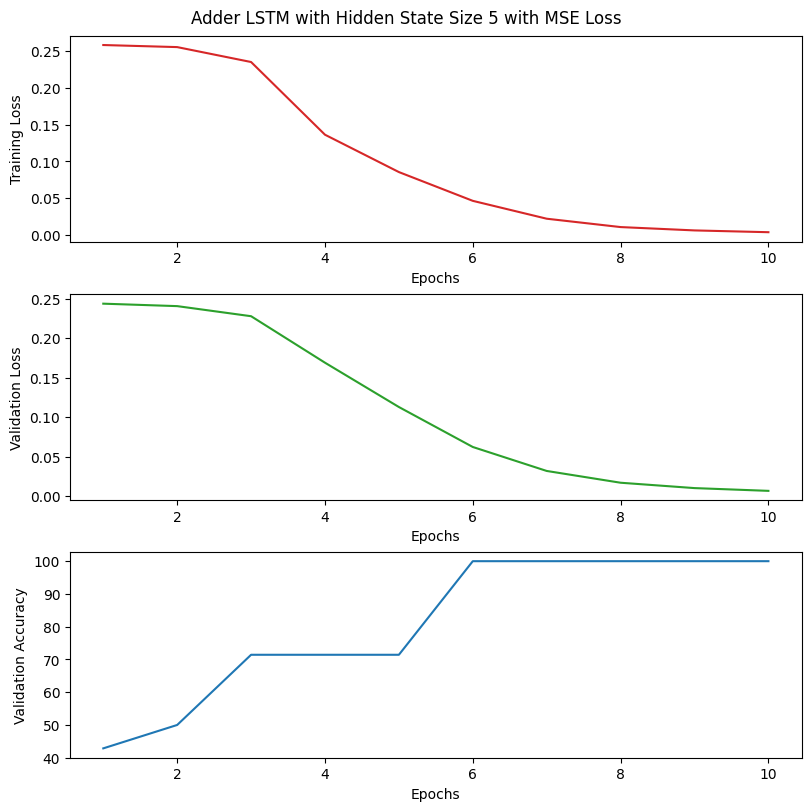

In [41]:
fig, axs = plt.subplots(3, constrained_layout= True, figsize=(8,8))
fig.suptitle('Adder LSTM with Hidden State Size 5 with MSE Loss')
axs[0].set(ylabel='Training Loss', xlabel='Epochs')
axs[0].plot(range(1,epochs+1),train_lossH5, 'tab:red')
axs[1].set(ylabel='Validation Loss', xlabel='Epochs')
axs[1].plot(range(1,epochs+1),val_lossH5, 'tab:green')
axs[2].set(ylabel='Validation Accuracy', xlabel='Epochs')
axs[2].plot(range(1,epochs+1),num_correctH5)

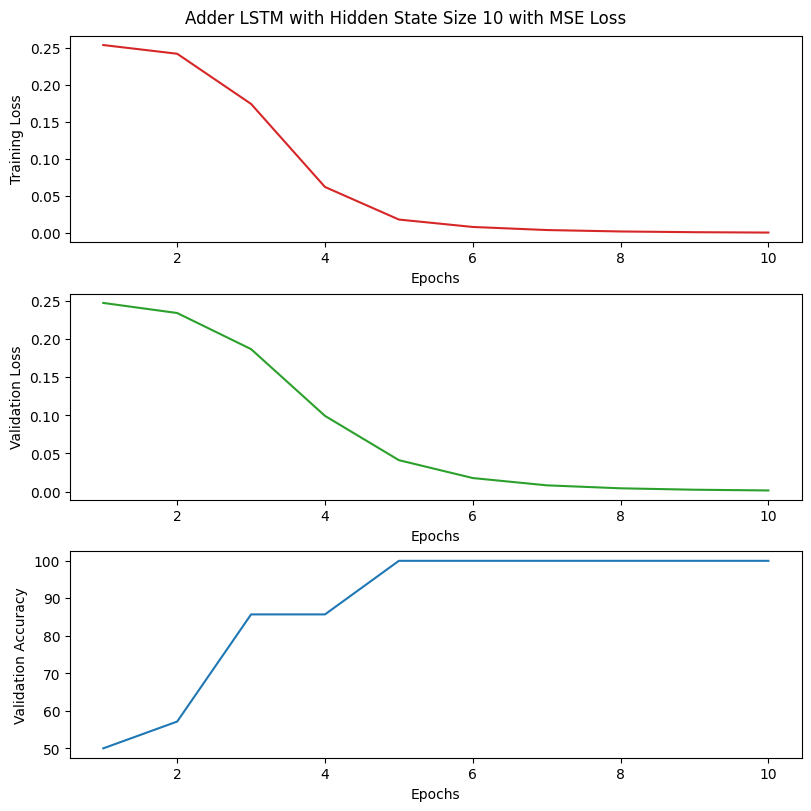

In [42]:
fig, axs = plt.subplots(3, constrained_layout= True, figsize=(8,8))
fig.suptitle('Adder LSTM with Hidden State Size 10 with MSE Loss')
axs[0].set(ylabel='Training Loss', xlabel='Epochs')
axs[0].plot(range(1,epochs+1),train_lossH10, 'tab:red')
axs[1].set(ylabel='Validation Loss', xlabel='Epochs')
axs[1].plot(range(1,epochs+1),val_lossH10, 'tab:green')
axs[2].set(ylabel='Validation Accuracy', xlabel='Epochs')
axs[2].plot(range(1,epochs+1),num_correctH10)

## Training adder LSTM with Cross Entropy loss criterion and different hidden state sizes

Different state vector sizes are chosen viz., 3, 5 and 10. The loss criterion is cross entropy (CE) loss.

### Training all model variations with CE loss criterion

In [43]:
# Fixing loss criterion
CE_criterion = nn.CrossEntropyLoss()

modelH3_CE = add_LSTM(3)
optimH3 = torch.optim.Adam(modelH3_CE.parameters(), learning_rate)
modelH5_CE = add_LSTM(5)
optimH5 = torch.optim.Adam(modelH5_CE.parameters(), learning_rate)
modelH10_CE = add_LSTM(10)
optimH10 = torch.optim.Adam(modelH10_CE.parameters(), learning_rate)

In [44]:
# Training

train_lossH3_CE, val_lossH3_CE, num_correctH3_CE  = train(modelH3_CE, CE_criterion, optimH3, train_in, train_out)
train_lossH5_CE, val_lossH5_CE, num_correctH5_CE  = train(modelH5_CE, CE_criterion, optimH5, train_in, train_out)
train_lossH10_CE, val_lossH10_CE, num_correctH10_CE  = train(modelH10_CE, CE_criterion, optimH10, train_in, train_out)

### Training and validation plots for all model variations with CE loss criterion

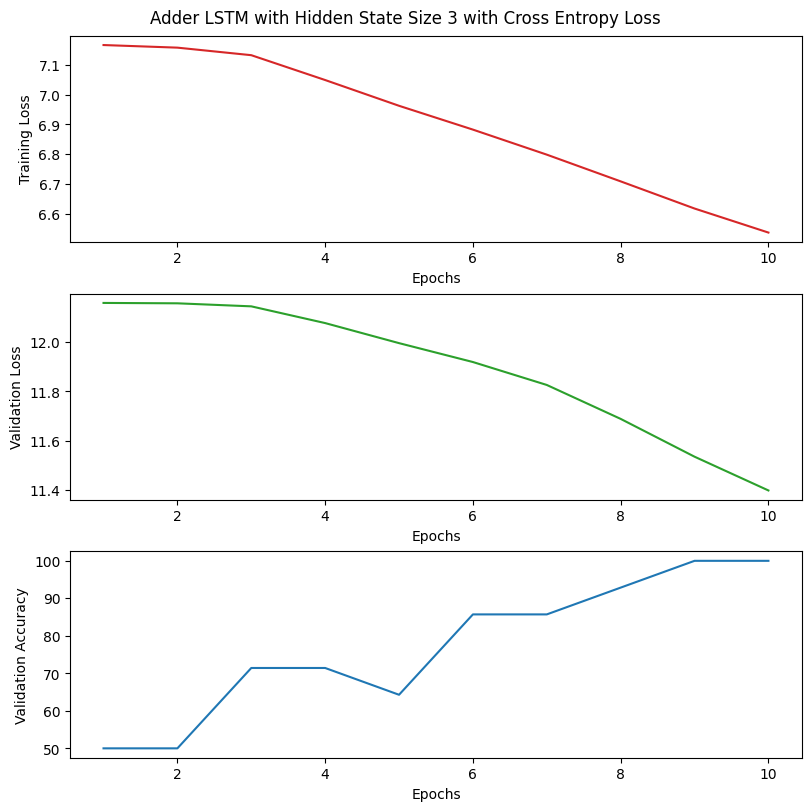

In [45]:
fig, axs = plt.subplots(3, constrained_layout= True, figsize=(8,8))
fig.suptitle('Adder LSTM with Hidden State Size 3 with Cross Entropy Loss')
axs[0].set(ylabel='Training Loss', xlabel='Epochs')
axs[0].plot(range(1,epochs+1),train_lossH3_CE, 'tab:red')
axs[1].set(ylabel='Validation Loss', xlabel='Epochs')
axs[1].plot(range(1,epochs+1),val_lossH3_CE, 'tab:green')
axs[2].set(ylabel='Validation Accuracy', xlabel='Epochs')
axs[2].plot(range(1,epochs+1),num_correctH3_CE)

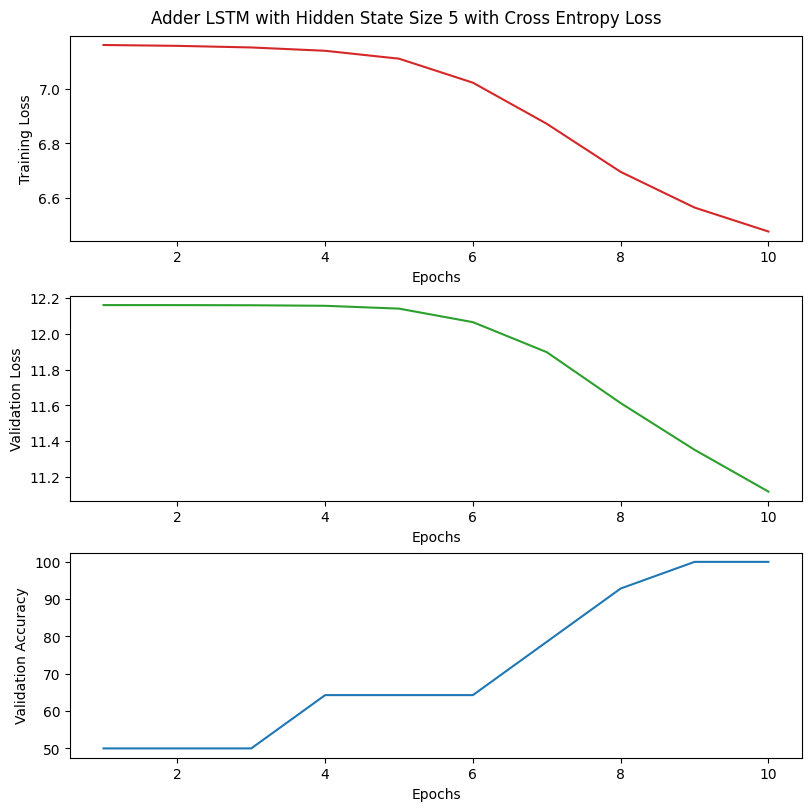

In [46]:
fig, axs = plt.subplots(3, constrained_layout= True, figsize=(8,8))
fig.suptitle('Adder LSTM with Hidden State Size 5 with Cross Entropy Loss')
axs[0].set(ylabel='Training Loss', xlabel='Epochs')
axs[0].plot(range(1,epochs+1),train_lossH5_CE, 'tab:red')
axs[1].set(ylabel='Validation Loss', xlabel='Epochs')
axs[1].plot(range(1,epochs+1),val_lossH5_CE, 'tab:green')
axs[2].set(ylabel='Validation Accuracy', xlabel='Epochs')
axs[2].plot(range(1,epochs+1),num_correctH5_CE)

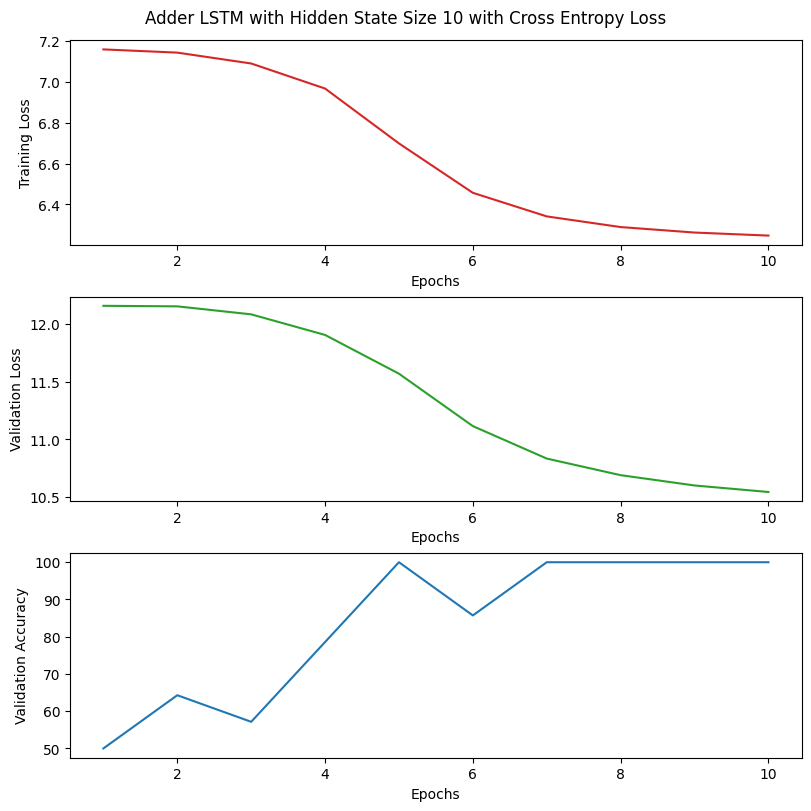

In [47]:
fig, axs = plt.subplots(3, constrained_layout= True, figsize=(8,8))
fig.suptitle('Adder LSTM with Hidden State Size 10 with Cross Entropy Loss')
axs[0].set(ylabel='Training Loss', xlabel='Epochs')
axs[0].plot(range(1,epochs+1),train_lossH10_CE, 'tab:red')
axs[1].set(ylabel='Validation Loss', xlabel='Epochs')
axs[1].plot(range(1,epochs+1),val_lossH10_CE, 'tab:green')
axs[2].set(ylabel='Validation Accuracy', xlabel='Epochs')
axs[2].plot(range(1,epochs+1),num_correctH10_CE)

## Comparing bit-accuracies of model variations

### Test dataset for checking bit accuracy

In [48]:
check_testin = []
check_testout = []
for j in range(1, 21):
  for i in range(100):
    a, b = gen_binary(j)
    check_testin.append(a)
    check_testout.append(b)

### Bit Accuracy function definition

In [49]:
def bit_accuracy(model, testin, testout):
  model.eval()
  correct = np.zeros(20)
  with torch.no_grad():
    for i in range(len(testin)):
      x = torch.zeros((1, testin[i].shape[0], testin[i].shape[1]))
      x[0] = torch.from_numpy(testin[i])
      out = model(x.float())

      target = torch.tensor(np.transpose(testout[i]))
      prediction = torch.zeros(out.shape)
      prediction[out>=0.5]=1
      prediction[out<0.5]=0

      correct[len(target)-1] += (prediction == target.float()).sum().item()/(len(target))

  return correct

### Bit accuracy for LSTM adder model with hidden state size 3

#### MSE Loss

The average bit accuracy over different input string lengths for adder LSTM with hidden state size 3 and MSE loss is  92.09664394063967


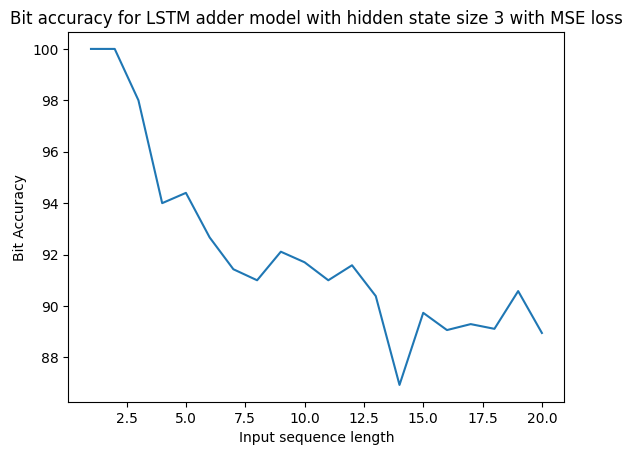

In [50]:
modelH3_MSE_BA = bit_accuracy(modelH3_MSE, check_testin, check_testout)
print('The average bit accuracy over different input string lengths for adder LSTM with hidden state size 3 and MSE loss is ',np.sum(modelH3_MSE_BA)/20)

plt.plot(np.arange(1,21), modelH3_MSE_BA)
plt.ylabel('Bit Accuracy')
plt.xlabel('Input sequence length')
plt.title('Bit accuracy for LSTM adder model with hidden state size 3 with MSE loss')
plt.show()

#### Cross Entropy Loss

The average bit accuracy over different input string lengths for adder LSTM with hidden state size 3 and Cross Entropy loss is  91.88119455900993


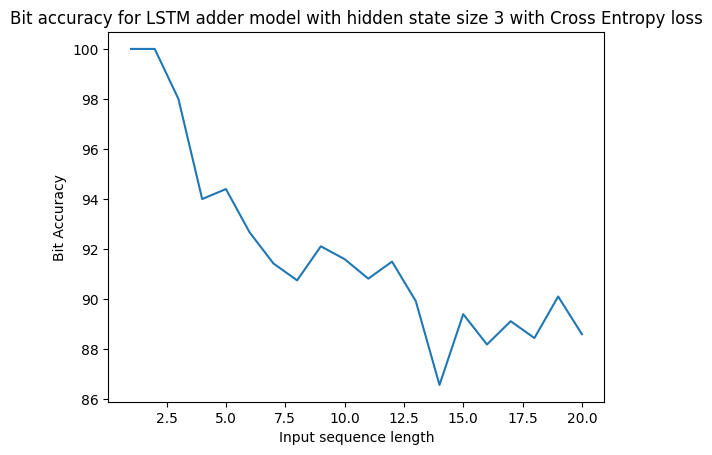

In [51]:
modelH3_CE_BA = bit_accuracy(modelH3_CE, check_testin, check_testout)
print('The average bit accuracy over different input string lengths for adder LSTM with hidden state size 3 and Cross Entropy loss is ',np.sum(modelH3_CE_BA)/20)

plt.plot(np.arange(1,21), modelH3_CE_BA)
plt.ylabel('Bit Accuracy')
plt.xlabel('Input sequence length')
plt.title('Bit accuracy for LSTM adder model with hidden state size 3 with Cross Entropy loss')
plt.show()

### Bit accuracy for LSTM adder model with hidden state size 5

#### MSE Loss

The average bit accuracy over different input string lengths for adder LSTM with hidden state size 5 and MSE loss is  99.99375


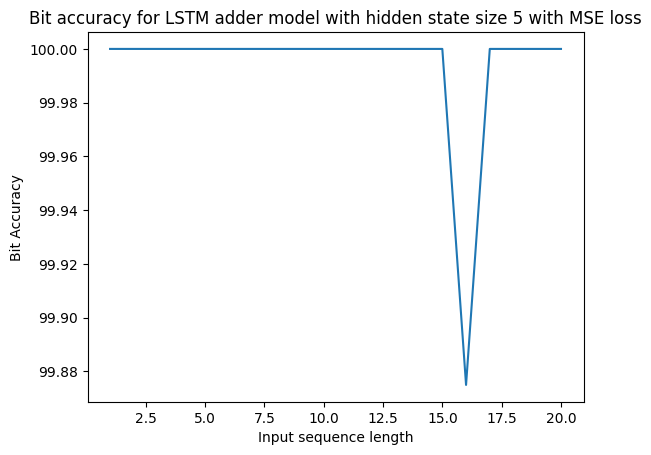

In [52]:
modelH5_MSE_BA = bit_accuracy(modelH5_MSE, check_testin, check_testout)
print('The average bit accuracy over different input string lengths for adder LSTM with hidden state size 5 and MSE loss is ',np.sum(modelH5_MSE_BA)/20)

plt.plot(np.arange(1,21), modelH5_MSE_BA)
plt.ylabel('Bit Accuracy')
plt.xlabel('Input sequence length')
plt.title('Bit accuracy for LSTM adder model with hidden state size 5 with MSE loss')
plt.show()

#### Cross Entropy Loss

The average bit accuracy over different input string lengths for adder LSTM with hidden state size 5 and Cross Entropy loss is  95.6402881146631


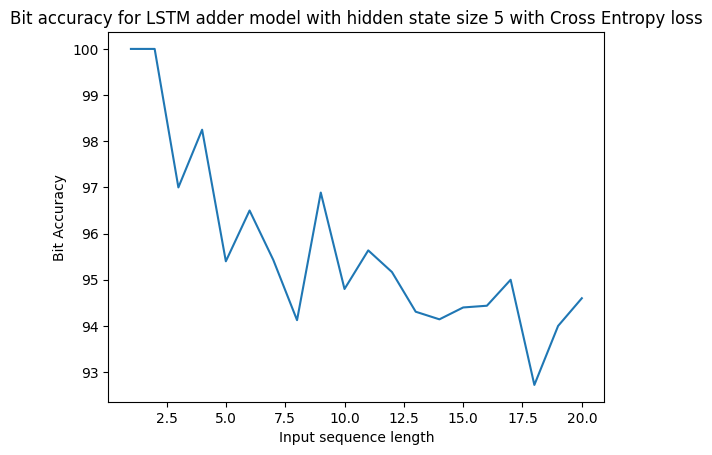

In [53]:
modelH5_CE_BA = bit_accuracy(modelH5_CE, check_testin, check_testout)
print('The average bit accuracy over different input string lengths for adder LSTM with hidden state size 5 and Cross Entropy loss is ',np.sum(modelH5_CE_BA)/20)

plt.plot(np.arange(1,21), modelH5_CE_BA)
plt.ylabel('Bit Accuracy')
plt.xlabel('Input sequence length')
plt.title('Bit accuracy for LSTM adder model with hidden state size 5 with Cross Entropy loss')
plt.show()

### Bit accuracy for LSTM adder model with hidden state size 10

#### MSE Loss

The average bit accuracy over different input string lengths for adder LSTM with hidden state size 10 and MSE loss is  100.0


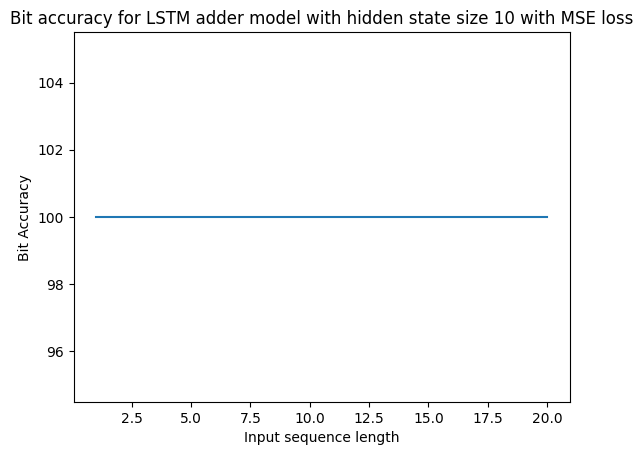

In [54]:
modelH10_MSE_BA = bit_accuracy(modelH10_MSE, check_testin, check_testout)
print('The average bit accuracy over different input string lengths for adder LSTM with hidden state size 10 and MSE loss is ',np.sum(modelH10_MSE_BA)/20)

plt.plot(np.arange(1,21), modelH10_MSE_BA)
plt.ylabel('Bit Accuracy')
plt.xlabel('Input sequence length')
plt.title('Bit accuracy for LSTM adder model with hidden state size 10 with MSE loss')
plt.show()

#### Cross Entropy Loss

The average bit accuracy over different input string lengths for adder LSTM with hidden state size 10 and MSE loss is  100.0


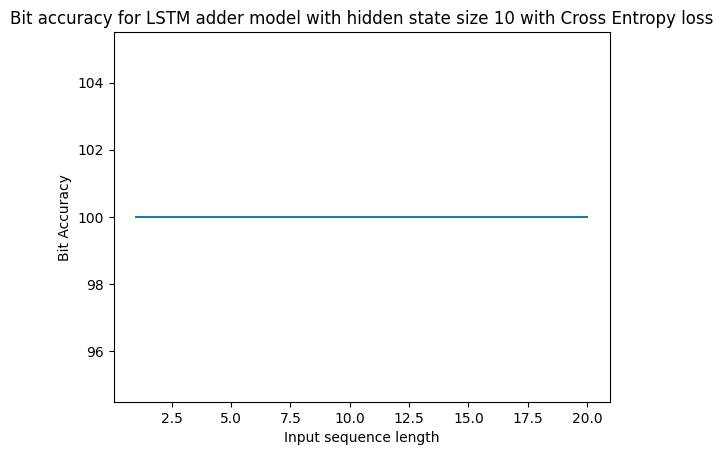

In [55]:
modelH10_CE_BA = bit_accuracy(modelH10_CE, check_testin, check_testout)
print('The average bit accuracy over different input string lengths for adder LSTM with hidden state size 10 and MSE loss is ',np.sum(modelH10_CE_BA)/20)

plt.plot(np.arange(1,21), modelH10_CE_BA)
plt.ylabel('Bit Accuracy')
plt.xlabel('Input sequence length')
plt.title('Bit accuracy for LSTM adder model with hidden state size 10 with Cross Entropy loss')
plt.show()

From the above experiments, we observe the following -

- Varying the state vector, we see that higher state vector size results in a higher average bit accuracy.

- MSE loss criterion resulted in a higher bit accuracy overall but this effect is overpowered by the hidden state vector size i.e., as the state vector size is increased, it is seen that bit accuracies for MSE and CE both are very close.

- Bit-accuracy decreased as the input length was increased. It decreased drastically for lower state vector sizes as they have lower learning capacity. 